# Reshaping data for model
### In this file, we will take the data that has been gathered and harmonized and we will fit it, create scenarios, and save it as a structured array for the model. Since we would like to keep the flexibility with excel, we will also save it in an ODYM compatible format and create a file that can do the reverse: if teh excel file is eddited, so is the array. This will be a separate script

In [4]:
# Load a local copy of the current ODYM branch:
import sys
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import pickle
import xlrd
import pylab
from copy import deepcopy
import logging as log
import xlwt
import tqdm
import math
from scipy.stats import norm
from openpyxl import *
from scipy.optimize import curve_fit
from scipy.stats import gompertz
from sklearn.metrics import r2_score
from logistic import logistic as logistic
from cycler import cycler
import seaborn as sns
import warnings
custom_cycler = cycler(color=sns.color_palette('Paired', 11)) #'Set2', 'Paired', 'YlGnBu'
### Preamble

# add ODYM module directory to system path, relative
MainPath = os.path.join('/Users/fernaag/Box/BATMAN/Coding/Global_model', 'odym', 'modules')
sys.path.insert(0, MainPath)

# add ODYM module directory to system path, absolute
sys.path.insert(0, os.path.join(os.getcwd(), 'odym', 'modules'))

# Specify path to dynamic stock model and to datafile, relative
DataPath = os.path.join( 'docs', 'files')

# Specify path to dynamic stock model and to datafile, absolute
DataPath = os.path.join('/Users/fernaag/Box/BATMAN/Coding/Global_model', 'docs', 'Files')

import ODYM_Classes as msc # import the ODYM class file
import ODYM_Functions as msf # import the ODYM function file
import dynamic_stock_model as dsm # import the dynamic stock model library

# Initialize loggin routine
log_verbosity = eval("log.DEBUG")
log_filename = 'LogFileTest.md'
[Mylog, console_log, file_log] = msf.function_logger(log_filename, os.getcwd(),
                                                     log_verbosity, log_verbosity)
Mylog.info('### 1. - Initialize.')

#Read main script parameters
#Load project-specific config file
ProjectSpecs_ConFile = 'ODYM_Config_Vehicle_System.xlsx'
Model_Configfile     = xlrd.open_workbook(os.path.join(DataPath, ProjectSpecs_ConFile))
ScriptConfig         = {'Model Setting': Model_Configfile.sheet_by_name('Config').cell_value(3,3)} # Dictionary with config parameters
Model_Configsheet    = Model_Configfile.sheet_by_name('Setting_' + ScriptConfig['Model Setting'])

Name_Scenario        = Model_Configsheet.cell_value(3,3)
print(Name_Scenario)

#Read control and selection parameters into dictionary
ScriptConfig         = msf.ParseModelControl(Model_Configsheet,ScriptConfig)

Mylog.info('Read and parse config table, including the model index table, from model config sheet.')
IT_Aspects,IT_Description,IT_Dimension,IT_Classification,IT_Selector,IT_IndexLetter,\
PL_Names,PL_Description,PL_Version,PL_IndexStructure,PL_IndexMatch,PL_IndexLayer,\
PrL_Number,PrL_Name,PrL_Comment,PrL_Type,ScriptConfig = msf.ParseConfigFile(Model_Configsheet,ScriptConfig,Mylog)    

class_filename       = 'ODYM_Classifications_Master_Vehicle_System.xlsx'
Classfile            = xlrd.open_workbook(os.path.join(DataPath,class_filename))
Classsheet           = Classfile.sheet_by_name('MAIN_Table')
MasterClassification = msf.ParseClassificationFile_Main(Classsheet,Mylog)

Mylog.info('Define model classifications and select items for model classifications according to information provided by config file.')
ModelClassification  = {} # Dict of model classifications
for m in range(0,len(IT_Aspects)):
    ModelClassification[IT_Aspects[m]] = deepcopy(MasterClassification[IT_Classification[m]])
    EvalString = msf.EvalItemSelectString(IT_Selector[m],len(ModelClassification[IT_Aspects[m]].Items))
    if EvalString.find(':') > -1: # range of items is taken
        RangeStart = int(EvalString[0:EvalString.find(':')])
        RangeStop  = int(EvalString[EvalString.find(':')+1::])
        ModelClassification[IT_Aspects[m]].Items = ModelClassification[IT_Aspects[m]].Items[RangeStart:RangeStop]           
    elif EvalString.find('[') > -1: # selected items are taken
        ModelClassification[IT_Aspects[m]].Items = [ModelClassification[IT_Aspects[m]].Items[i] for i in eval(EvalString)]
    elif EvalString == 'all':
        None
    else:
        Mylog.error('Item select error for aspect ' + IT_Aspects[m] + ' were found in datafile.')
        break

# Define model index table and parameter dictionary
Mylog.info('### 2.2 - Define model index table and parameter dictionary')
Model_Time_Start = int(min(ModelClassification['Time'].Items))
Model_Time_End   = int(max(ModelClassification['Time'].Items))
Model_Duration   = Model_Time_End - Model_Time_Start + 1

Mylog.info('Define index table dataframe.')
IndexTable = pd.DataFrame({'Aspect'        : IT_Aspects,  # 'Time' and 'Element' must be present!
                           'Description'   : IT_Description,
                           'Dimension'     : IT_Dimension,
                           'Classification': [ModelClassification[Aspect] for Aspect in IT_Aspects],
                           'IndexLetter'   : IT_IndexLetter})  # Unique one letter (upper or lower case) indices to be used later for calculations.

# Default indexing of IndexTable, other indices are produced on the fly
IndexTable.set_index('Aspect', inplace=True)

# Add indexSize to IndexTable:
IndexTable['IndexSize'] = pd.Series([len(IndexTable.Classification[i].Items) for i in range(0, len(IndexTable.IndexLetter))],
                                    index=IndexTable.index)

# list of the classifications used for each indexletter
IndexTable_ClassificationNames = [IndexTable.Classification[i].Name for i in range(0, len(IndexTable.IndexLetter))]

# Define dimension sizes
Nt = len(IndexTable.Classification[IndexTable.index.get_loc('Time')].Items)
Nc = len(IndexTable.Classification[IndexTable.index.get_loc('Age-cohort')].Items)
Ng = len(IndexTable.Classification[IndexTable.index.get_loc('Good')].Items)
Nr = len(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items)
Ne = len(IndexTable.Classification[IndexTable.index.get_loc('Element')].Items)
Nb = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Chemistry')].Items)
Np = len(IndexTable.Classification[IndexTable.index.get_loc('Battery_Parts')].Items)
Ns = len(IndexTable.Classification[IndexTable.index.get_loc('Segment')].Items)
Nh = len(IndexTable.Classification[IndexTable.index.get_loc('Recycling_Process')].Items)
NS = len(IndexTable.Classification[IndexTable.index.get_loc('Scenario')].Items)
Nz = len(IndexTable.Classification[IndexTable.index.get_loc('Stock_Scenarios')].Items)
No = len(IndexTable.Classification[IndexTable.index.get_loc('Ownership_Scenarios')].Items)

INFO (<ipython-input-4-82906cba0167> <<module>>): ### 1. - Initialize.
INFO (<ipython-input-4-82906cba0167> <<module>>): Read and parse config table, including the model index table, from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read parameter list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read process list from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model run control from model config sheet.
INFO (ODYM_Functions.py <ParseConfigFile>): Read model output control from model config sheet.


Vehicle stock model for Global fleet


INFO (ODYM_Functions.py <ParseClassificationFile_Main>): End of file or formatting error while reading the classification file in column 20. Check if all classifications are present. If yes, you are good to go!
INFO (<ipython-input-4-82906cba0167> <<module>>): Define model classifications and select items for model classifications according to information provided by config file.
INFO (<ipython-input-4-82906cba0167> <<module>>): ### 2.2 - Define model index table and parameter dictionary
INFO (<ipython-input-4-82906cba0167> <<module>>): Define index table dataframe.


# Now we import the stock for those regions according to OICA after harmonization by Eric

In [5]:
stock = pd.read_pickle('/Users/fernaag/Box/BATMAN/Data/Database/data/02_harmonized_data/IUS_OICA_Global_2005_2015/stocks_region_country_OICA')

In [6]:
stock['vehicle_segment'].unique()

array(['a151', 'all', 'b100', 'b125', 'b150'], dtype=object)

In [7]:
stock_oica = stock[(stock['source']== 'OICA')& (stock['vehicle_class']=='OIPC')] # Import only OICA data for passenger cars (OIPC)

In [8]:
stock_oica.drop(['id', 'date_of_measurement', 'geo', 'process', 'model_year', 'drive_train', 'year_of_first_registraion', 'accessed', 'notebook', 'footnote', 'source'], axis=1, inplace= True)

/Users/fernaag/opt/anaconda3/envs/IAM/lib/python3.7/site-packages/pandas/core/frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
stock_oica['country'].unique() # Seems like only Europe is included here as a country

array(['\xa0Europe', 'Austria', 'Belgium', 'Denmark', 'Finland', 'France',
       'Germany', 'Greece', 'Iceland', 'Ireland', 'Italy', 'Luxembourg',
       'Netherlands', 'Norway', 'Portugal', 'Spain', 'Sweden',
       'Switzerland',
       'United Kingdom of Great Britain and Northern Ireland', 'Bulgaria',
       'Croatia', 'Cyprus', 'Czechia', 'Estonia', 'Hungary', 'Latvia',
       'Lithuania', 'Malta', 'Poland', 'Romania', 'Slovakia', 'Slovenia',
       'Albania', 'Belarus', 'Bosnia and Herzegovina', 'Georgia',
       'North Macedonia', 'Republic of Moldova', 'Russian Federation',
       'Serbia', 'Turkey', 'Ukraine', 'United States of America',
       'Canada', 'Mexico', 'Argentina', 'Bahamas', 'Barbados', 'Belize',
       'Bermuda', 'Bolivia (Plurinational State of)', 'Brazil', 'Chile',
       'Colombia', 'Costa Rica', 'Cuba', 'Dominican Republic', 'Ecuador',
       'El Salvador', 'Guatemala', 'Haiti', 'Honduras', 'Jamaica',
       'Nicaragua', 'Panama', 'Paraguay', 'Peru', 'Puerto

In [10]:
stock_oica['region'].unique()

array(['\xa0Europe', 'Europe', 'Asia', 'Americas', 'Oceania',
       '\xa0Africa', 'Africa', nan], dtype=object)

## This dataset is somehow not looking complete. We use instead the most recently downloaded file direclty from OICA without harmonization

In [11]:
ius = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/IUS_passengerCars_OICA_2005_2015/PC_Vehicles-in-use.xlsx', skiprows=5)

In [12]:
ius['REGIONS/COUNTRIES'].unique()

array([nan, 'EUROPE', 'EU 28 countries + EFTA', 'EU 15 countries + EFTA',
       'AUSTRIA', 'BELGIUM', 'DENMARK', 'FINLAND', 'FRANCE', 'GERMANY',
       'GREECE', 'ICELAND', 'IRELAND', 'ITALY', 'LUXEMBOURG',
       'NETHERLANDS', 'NORWAY', 'PORTUGAL', 'SPAIN', 'SWEDEN',
       'SWITZERLAND', 'UNITED KINGDOM', 'EUROPE NEW MEMBERS', 'BULGARIA',
       'CROATIA', 'CYPRUS', 'CZECH REPUBLIC', 'ESTONIA', 'HUNGARY',
       'LATVIA', 'LITHUANIA', 'MALTA', 'POLAND', 'ROMANIA', 'SLOVAKIA',
       'SLOVENIA', 'RUSSIA, TURKEY & OTHER EUROPE', 'ALBANIA', 'BELARUS',
       'BOSNIA', 'GEORGIA', 'MACEDONIA', 'MOLDAVIA', 'RUSSIA', 'SERBIA',
       'TURKEY', 'UKRAINE', 'AMERICA', 'NAFTA', 'CANADA', 'MEXICO',
       'UNITED STATES OF AMERICA', 'CENTRAL & SOUTH AMERICA', 'ARGENTINA',
       'BAHAMAS', 'BARBADOS', 'BELIZE', 'BERMUDA', 'BOLIVIA', 'BRAZIL',
       'CHILE', 'COLOMBIA', 'COSTA RICA', 'CUBA', 'DOMINICAN REPUBLIC',
       'ECUADOR', 'EL SALVADOR', 'GUATEMALA', 'HAITI', 'HONDURAS',
       'JAMAIC

In [13]:
ius = ius[(ius['REGIONS/COUNTRIES']=='EUROPE') | (ius['REGIONS/COUNTRIES']=='CHINA')| (ius['REGIONS/COUNTRIES']=='JAPAN')| (ius['REGIONS/COUNTRIES']=='SOUTH KOREA') | (ius['REGIONS/COUNTRIES']=='NAFTA')| (ius['REGIONS/COUNTRIES']=='ALL COUNTRIES')| (ius['REGIONS/COUNTRIES']=='UNITED STATES OF AMERICA')| (ius['REGIONS/COUNTRIES']=='MEXICO')| (ius['REGIONS/COUNTRIES']=='CANADA')]

In [14]:
ius = ius.melt(['REGIONS/COUNTRIES']).dropna()

## The US seems to have some different definitions, so we will add the national data and compute registrations separately

In [15]:
stock_bts = pd.read_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/01_raw_data/IUS_allVehicles_USA_BTS/table_01_11_011321.xlsx', skiprows=1)

In [16]:
ldv_short = stock_bts[(stock_bts['Unnamed: 0']== 'Light duty vehicle, short wheel basec,d') ]
ldv_long = stock_bts[(stock_bts['Unnamed: 0']== 'Light duty vehicle, long wheel basec') ]

In [17]:
ldv = stock_bts[(stock_bts['Unnamed: 0']== 'Light duty vehicle, short wheel basec,d') | (stock_bts['Unnamed: 0']== 'Light duty vehicle, long wheel basec')]

In [18]:
ldv= ldv.melt()

In [19]:
ldv.drop(index=[0,1], inplace=True)

In [20]:
ldv = ldv.groupby('variable').sum()

In [21]:
ldv.dropna(inplace=True)

We will introduce a correction factor based on the assumption that some commercial vehicles fall under the category of long wheel base light duty vehicles. 

In [22]:
ldv_long = ldv_long.melt()

In [23]:
ldv_long.drop(index=[0,1,2], inplace=True)

In [24]:
ldv_long.set_index('variable', inplace=True)

In [25]:
c_factor = 0.5
ldv_long_corr = ldv_long*c_factor

In [26]:
ldv_short = ldv_short.melt()

In [27]:
ldv_short.rename(columns= {'variable': 'year'}, inplace=True)

In [28]:
ldv_short.set_index('year', inplace=True)

In [29]:
ldv_corr = pd.concat(([ldv_short, ldv_long_corr]))

In [30]:
#ldv.drop(index= 'Unnamed: 0', inplace=True)
ldv_corr.drop(index= 'Unnamed: 0', inplace=True)


In [31]:
ldv_corr.reset_index(inplace=True)

In [32]:
ldv_corr = ldv_corr.groupby(['index']).sum().dropna()

In [33]:
ldv['REGIONS/COUNTRIES'] = 'UNITED STATES OF AMERICA'
ldv_corr['REGIONS/COUNTRIES'] = 'UNITED STATES OF AMERICA'


## Now we harmonize the data from the population and vehicle stock

In [34]:
ius['REGIONS/COUNTRIES'].unique()

array(['EUROPE', 'NAFTA', 'CANADA', 'MEXICO', 'UNITED STATES OF AMERICA',
       'CHINA', 'JAPAN', 'SOUTH KOREA', 'ALL COUNTRIES'], dtype=object)

## Creating regions for stock

In [35]:
ius.rename(columns={'variable':'year'}, inplace=True)

In [36]:
ius.set_index('year', inplace=True)

In [37]:
ius.drop(index='Variation 2015/2014', inplace=True)

In [38]:
for i in range(len(ius.index.values)): ius.index.values[i]= int(ius.index.values[i])

In [39]:
sk_jp = ius[ius['REGIONS/COUNTRIES']=='SOUTH KOREA'] + ius[ius['REGIONS/COUNTRIES']=='JAPAN']
sk_jp['REGIONS/COUNTRIES'] = 'SOUTH KOREA AND JAPAN'

In [40]:
nt_am = ius[ius['REGIONS/COUNTRIES']=='CANADA']['value'] + ldv['value']/1000
nt_am = pd.DataFrame(nt_am)
nt_am.dropna(inplace=True)
nt_am.rename_axis('year', inplace=True)
nt_am['REGIONS/COUNTRIES']='US AND CANADA'

We need to be careful here. Since we have two definitions for the US, the ROW stock may be affected. We will therefore subtract only the passenger stock as reported by OICA from the total fleet, not the one computed using national statistics

In [41]:
row = ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'] - ius[ius['REGIONS/COUNTRIES']=='UNITED STATES OF AMERICA']['value']- ius[ius['REGIONS/COUNTRIES']=='CANADA']['value'] - ius[ius['REGIONS/COUNTRIES']=='EUROPE']['value'] - ius[ius['REGIONS/COUNTRIES']=='JAPAN']['value'] - ius[ius['REGIONS/COUNTRIES']=='SOUTH KOREA']['value'] - ius[ius['REGIONS/COUNTRIES']=='CHINA']['value']
row = pd.DataFrame(row)
row.rename_axis('year', inplace=True)
row['REGIONS/COUNTRIES']='ROW'

In [42]:
eu = ius[ius['REGIONS/COUNTRIES']=='EUROPE']
pc = ius[ius['REGIONS/COUNTRIES']=='CHINA']

In [43]:
ius_regions = pd.concat(([sk_jp, nt_am, row, eu, pc]))
ius_regions['REGIONS/COUNTRIES'].unique()

ipykernel_launcher:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



array(['SOUTH KOREA AND JAPAN', 'US AND CANADA', 'ROW', 'EUROPE', 'CHINA'],
      dtype=object)

In [44]:
(ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'] - ius[ius['REGIONS/COUNTRIES']=='UNITED STATES OF AMERICA']['value']+ ldv['value']/1000).dropna()

2005         752850
2006         778632
2007         802146
2008         827971
2009         849867
2010         876964
2011         914665
2012         947775
2013         984879
2014    1.02623e+06
2015    1.06767e+06
Name: value, dtype: object

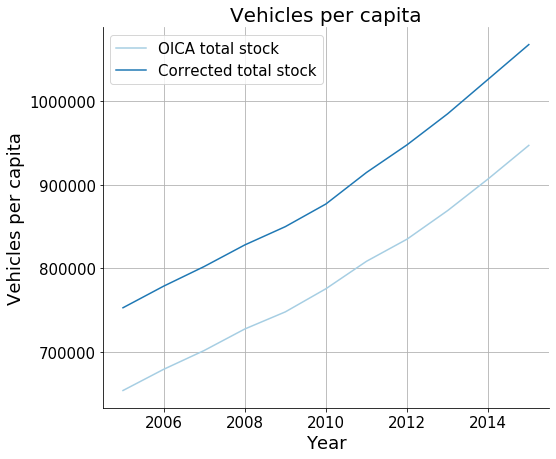

In [45]:
import logging
mpl_logger = logging.getLogger("matplotlib")
mpl_logger.setLevel(logging.WARNING)  
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)

ax.plot(ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'].index.values, 
        ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'].values)
ax.plot(ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'].index.values, 
        (ius[ius['REGIONS/COUNTRIES']=='ALL COUNTRIES']['value'] - ius[ius['REGIONS/COUNTRIES']=='UNITED STATES OF AMERICA']['value']+ ldv['value']/1000).dropna())
ax.set_ylabel('Vehicles per capita',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
warnings.filterwarnings("ignore")
top.set_visible(False)
plt.grid()
ax.legend(['OICA total stock', 'Corrected total stock'], loc='upper left',prop={'size':15})
ax.set_title('Vehicles per capita', fontsize=20)
ax.set_xlabel('Year',fontsize =18)
ax.tick_params(axis='both', which='major', labelsize=15)


## Calculating historic vehicles per capita

In [46]:
pop_regions_scenarios = pd.read_pickle('/Users/fernaag/Box/BATMAN/Data/Database/data/02_harmonized_data/population_Global/population_UN_regions_scenarios')

In [47]:
pop_regions = pop_regions_scenarios[pop_regions_scenarios.index.get_level_values('Variant')=='Medium']

In [48]:
pop_regions.reset_index(inplace=True)
pop_regions.drop(columns='Variant', inplace=True)
pop_regions.rename({'Location': 'Region', 'Time': 'year', 'PopTotal': 'value'}, axis=1, inplace=True)
pop_regions.set_index(['year', 'Region'], inplace=True)
pop_regions.head()

,,value
year,Region,
1950,EUROPE,549328.859
1951,EUROPE,554324.506
1952,EUROPE,559694.362
1953,EUROPE,565281.964
1954,EUROPE,570969.740


In [49]:
pop_regions = pop_regions[pop_regions.index.get_level_values('year')<2051]

In [50]:
ius_regions.reset_index(inplace=True)

In [51]:
gl_ius = ius_regions.groupby('year').sum()
gl_ius['REGIONS/COUNTRIES'] = 'GLOBAL'

In [52]:
ius_regions.set_index('year', inplace=True)

In [53]:
ius_regions = pd.concat([ius_regions, gl_ius])

In [54]:
ius_regions.rename(columns= {'REGIONS/COUNTRIES':'Region'}, inplace=True)
ius_regions.reset_index(inplace=True)
ius_regions.rename(columns= {'index':'year'}, inplace=True)
ius_regions.set_index(['year', 'Region'], inplace=True)

In [55]:
ius_regions.head()

,,value
year,Region,
2005,SOUTH KOREA AND JAPAN,68213
2006,SOUTH KOREA AND JAPAN,69128
2007,SOUTH KOREA AND JAPAN,69724
2008,SOUTH KOREA AND JAPAN,70349
2009,SOUTH KOREA AND JAPAN,71044


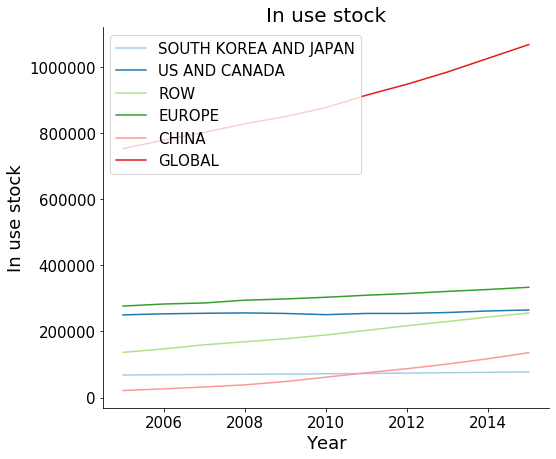

In [56]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
for i,r in enumerate(ius_regions.index.get_level_values('Region').unique()):
    ax.plot(ius_regions[ius_regions.index.get_level_values('Region')==r].index.get_level_values('year').values, 
            ius_regions[ius_regions.index.get_level_values('Region')==r].value.values)
    ax.set_ylabel('In use stock',fontsize =18)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top = ax.spines["top"]
    top.set_visible(False)
    plt.grid()
    ax.legend(ius_regions.index.get_level_values('Region').unique(), loc='upper left',prop={'size':15})
    ax.set_title('In use stock', fontsize=20)
    ax.set_xlabel('Year',fontsize =18)
    ax.tick_params(axis='both', which='major', labelsize=15)


In [57]:
vpc_regions = ius_regions / pop_regions
vpc_regions.dropna(inplace=True)

In [58]:
vpc_regions.reset_index(inplace=True)
vpc_regions.set_index('year', inplace=True)

In [59]:
vpc_regions_sorted = vpc_regions.sort_values('value', ascending=False)

In [60]:
vpc_regions.head()

,Region,value
year,,
2005,CHINA,0.0160245
2005,EUROPE,0.37936
2005,GLOBAL,0.115081
2005,ROW,0.0343469
2005,SOUTH KOREA AND JAPAN,0.385325


In [61]:
pop_regions.head()

,,value
year,Region,
1950,EUROPE,549328.859
1951,EUROPE,554324.506
1952,EUROPE,559694.362
1953,EUROPE,565281.964
1954,EUROPE,570969.740


In [62]:
vpc_regions.to_excel('/Users/fernaag/Box/BATMAN/Data/Database/data/02_harmonized_data/VpC_Global_2019_2050/VpC_historic_OICA.xlsx')

## Plotting the results

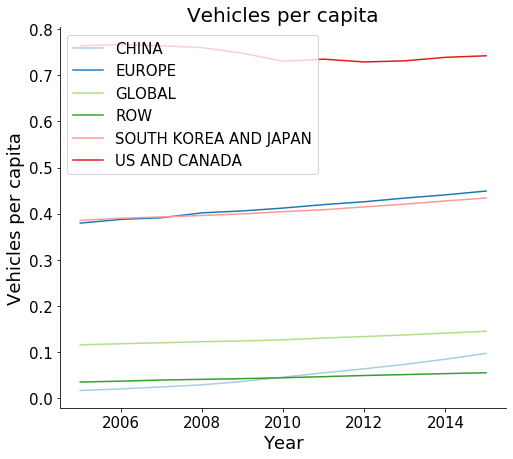

In [63]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
for i,r in enumerate(vpc_regions['Region'].unique()):
    ax.plot(vpc_regions[vpc_regions['Region']==r].index.values, 
            vpc_regions[vpc_regions['Region']==r].value.values)
    ax.set_ylabel('Vehicles per capita',fontsize =18)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top = ax.spines["top"]
    top.set_visible(False)
    plt.grid()
    ax.legend(vpc_regions['Region'].unique(), loc='upper left',prop={'size':15})
    ax.set_title('Vehicles per capita', fontsize=20)
    ax.set_xlabel('Year',fontsize =18)
    ax.tick_params(axis='both', which='major', labelsize=15)


## Fitting functions for the baseline

In [64]:
t = np.arange(1950,2051)
vpc_fit = np.zeros((Nr, Nt))
for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
    popt, pcov = curve_fit(logistic, vpc_regions[vpc_regions['Region']==r].index.values, vpc_regions[vpc_regions['Region']==r].value.values, bounds=([min(vpc_regions[vpc_regions['Region']==r].index.values), 0., 0.01, 0.], [max(vpc_regions[vpc_regions['Region']==r].index.values), 100, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
    vpc_fit[i,:] = logistic(t, *popt)
    print(r)

US AND CANADA
EUROPE
SOUTH KOREA AND JAPAN
CHINA
ROW
GLOBAL


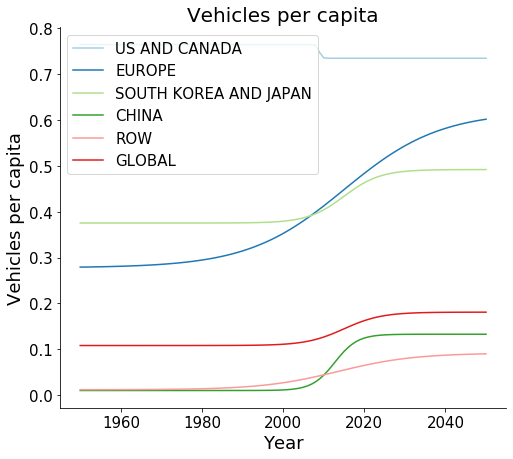

In [65]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
    ax.plot(t, 
            vpc_fit[i,:])
    #ax.plot(vpc_regions[vpc_regions['Region']==r].index.values, 
     #       vpc_regions[vpc_regions['Region']==r].value.values, 'x')
    ax.set_ylabel('Vehicles per capita',fontsize =18)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top = ax.spines["top"]
    top.set_visible(False)
    plt.grid()
    ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items, loc='upper left',prop={'size':15})
    ax.set_title('Vehicles per capita', fontsize=20)
    ax.set_xlabel('Year',fontsize =18)
    ax.tick_params(axis='both', which='major', labelsize=15)

## Creating VpC scenarios 

In [66]:
### Low scenario: The vehicle ownership remains at 2020 levels
t_hist = np.arange(0,66) # Values until 2015
t_fut = np.arange(66,101) # Values from 2016 onwards
vpc_low = np.zeros((Nr, Nt))
for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
    vpc_low[i,t_hist] = vpc_fit[i,t_hist]
    vpc_low[i, t_fut] = vpc_regions[vpc_regions['Region']==r].value.values[-1]

In [67]:
### High scenario: 20% higher than BAU
t_hist = np.arange(0,66) # Values until 2015
t_fut = np.arange(66,101) # Values from 2016 onwards
vpc_high = np.zeros((Nr, Nt))
for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
    vpc_high[i,t_hist] = vpc_fit[i,t_hist]
    vpc_high[i, t_fut] = vpc_fit[i,t_fut] * 1.2

In [68]:
### Now we smoothen the scenarios
for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
    popt, pcov = curve_fit(logistic, t, vpc_low[i,:], bounds=([min(vpc_regions[vpc_regions['Region']==r].index.values), 0., 0.01, 0.], [max(vpc_regions[vpc_regions['Region']==r].index.values), 100, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
    vpc_low[i,:] = logistic(t, *popt)
for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
    popt, pcov = curve_fit(logistic, t, vpc_high[i,:], bounds=([min(vpc_regions[vpc_regions['Region']==r].index.values), 0., 0.01, 0.], [max(vpc_regions[vpc_regions['Region']==r].index.values), 100, 1, 1])) # Bounds are set as ([low_ti, low_tau, low_Co, low_C1],[high_ti,high_tau, high_Co, high_C1 ])
    vpc_high[i,:] = logistic(t, *popt)

In [69]:
### Creating array with scenarios
vpc_scen = np.zeros((No, Nr, Nt))
vpc_scen[0,:,:]= vpc_low
vpc_scen[1,:,:]= vpc_fit
vpc_scen[2,:,:]= vpc_high

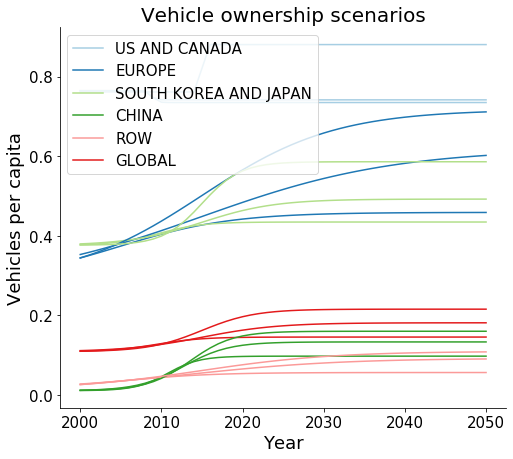

In [87]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
for j, o in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Ownership_Scenarios')].Items):
    ax.set_prop_cycle(custom_cycler)
    for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
        ax.plot(t[50:], 
                vpc_scen[j,i,50:])
        #ax.plot(vpc_regions[vpc_regions['Region']==r].index.values, 
        #       vpc_regions[vpc_regions['Region']==r].value.values, 'x')
        ax.set_ylabel('Vehicles per capita',fontsize =18)
        right_side = ax.spines["right"]
        right_side.set_visible(False)
        top = ax.spines["top"]
        top.set_visible(False)
        plt.grid()
        ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items, loc='upper left',prop={'size':15})
        ax.set_title('Vehicle ownership scenarios', fontsize=20)
        ax.set_xlabel('Year',fontsize =18)
        ax.tick_params(axis='both', which='major', labelsize=15)

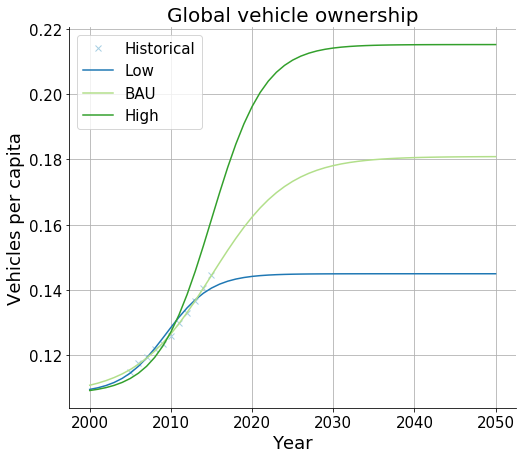

In [90]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
ax.plot(vpc_regions[vpc_regions['Region']=='GLOBAL'].index.values, 
            vpc_regions[vpc_regions['Region']=='GLOBAL'].value.values, 'x')
for j, o in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Ownership_Scenarios')].Items):
    ax.plot(t[50:], 
            vpc_scen[j,5,50:])
    #ax.plot(vpc_regions[vpc_regions['Region']==r].index.values, 
    #       vpc_regions[vpc_regions['Region']==r].value.values, 'x')
    ax.set_ylabel('Vehicles per capita',fontsize =18)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top = ax.spines["top"]
    top.set_visible(False)
    plt.grid()
    ax.legend(['Historical'] + IndexTable.Classification[IndexTable.index.get_loc('Ownership_Scenarios')].Items, loc='upper left',prop={'size':15})
    ax.set_title('Global vehicle ownership', fontsize=20)
    ax.set_xlabel('Year',fontsize =18)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.savefig('/Users/fernaag/Box/BATMAN/Coding/Global_model/results/overview/global_vpc.png')

## Calculating total stocks per region

In [72]:
vpc = pd.DataFrame(vpc_fit, index=vpc_regions['Region'].unique())

In [73]:
vpc.reset_index(inplace=True)

In [74]:
time = np.arange(1950,2051)
for i in range(101):
    vpc.rename(columns={i: time[i], 'index':'Region'}, inplace=True)


In [75]:
vpc = vpc.melt('Region')

In [76]:
pop_regions.reset_index(inplace=True)

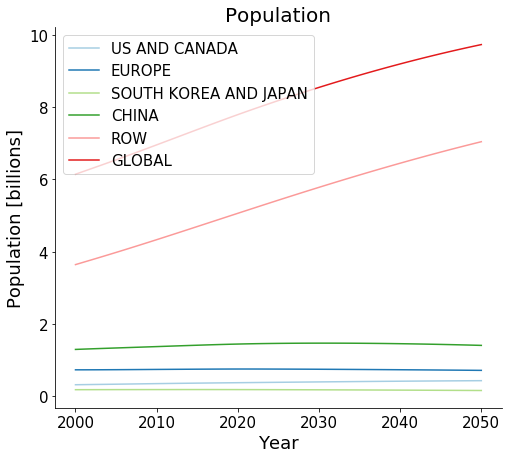

In [91]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
for i,r in enumerate(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items):
    ax.plot(pop_regions[pop_regions['Region']==r].year.values[50:], 
            pop_regions[pop_regions['Region']==r].value.values[50:]/1000000)
            
    #ax.plot(vpc_regions[vpc_regions['Region']==r].index.values, 
     #       vpc_regions[vpc_regions['Region']==r].value.values, 'x')
    ax.set_ylabel('Population [billions]',fontsize =18)
    right_side = ax.spines["right"]
    right_side.set_visible(False)
    top = ax.spines["top"]
    top.set_visible(False)
    plt.grid()
    ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Region')].Items, loc='upper left',prop={'size':15})
    ax.set_title('Population', fontsize=20)
    ax.set_xlabel('Year',fontsize =18)
    ax.tick_params(axis='both', which='major', labelsize=15)

In [78]:
PopArray = np.zeros((Nr, Nt))
for m in range(0,len(pop_regions.value.values)):
    #ScenPosition = TODO: Add population scenario to indexes
    RegionPosition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index(pop_regions['Region'].iloc[m])
    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(pop_regions['year'].iloc[m])
    PopArray[RegionPosition, Timeposition] = pop_regions['value'].iloc[m]

In [79]:
#VpCArray = np.zeros((Nz,Nr, Nt))
#for m in range(0,len(vpc.value.values)):
#    ScenPosition = TODO: Add VpC scenario to indexes
#    RegionPosition = IndexTable.Classification[IndexTable.index.get_loc('Region')].Items.index(vpc['Region'].iloc[m])
#    Timeposition = IndexTable.Classification[IndexTable.index.get_loc('Time')].Items.index(vpc['variable'].iloc[m])
#    VpCArray[, RegionPosition, Timeposition] = vpc['value'].iloc[m]

In [80]:
# We only use the baseline population scenario and all defined ownership scenarios
StockArray = np.zeros(( Nz, Nr, Nt))
StockArray[:,:,:] = np.einsum('rt,ort->ort', PopArray*1000, vpc_scen)
#StockArray[:,5,:] = np.einsum('rt,rt->t', PopArray, VpCArray)

In [81]:
vpc_scen[2,5,:]

array([0.10822213, 0.10822213, 0.10822213, 0.10822213, 0.10822213,
       0.10822213, 0.10822213, 0.10822213, 0.10822213, 0.10822213,
       0.10822213, 0.10822213, 0.10822214, 0.10822214, 0.10822214,
       0.10822215, 0.10822216, 0.10822217, 0.10822219, 0.10822221,
       0.10822224, 0.10822227, 0.10822233, 0.1082224 , 0.1082225 ,
       0.10822263, 0.10822281, 0.10822305, 0.10822339, 0.10822384,
       0.10822445, 0.10822529, 0.10822642, 0.10822797, 0.10823006,
       0.10823291, 0.10823678, 0.10824204, 0.10824919, 0.1082589 ,
       0.10827209, 0.10829001, 0.10831436, 0.10834743, 0.10839234,
       0.1084533 , 0.10853604, 0.10864827, 0.10880041, 0.10900647,
       0.10928521, 0.10966167, 0.11016899, 0.11085064, 0.11176291,
       0.11297735, 0.11458269, 0.1166851 , 0.11940512, 0.12286929,
       0.12719387, 0.13245982, 0.1386811 , 0.14577383, 0.15353905,
       0.1616724 , 0.16980574, 0.17757097, 0.18466369, 0.19088498,
       0.19615092, 0.2004755 , 0.20393967, 0.2066597 , 0.20876

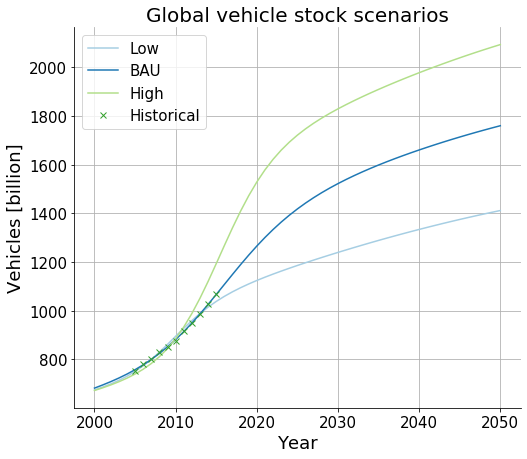

In [82]:
fig, ax = plt.subplots(figsize=(8,7))
ax.set_prop_cycle(custom_cycler)
ax.plot(t[50:], 
        np.moveaxis(StockArray[:,5,50:]/1000000, 0,1))
ax.plot(ius_regions[ius_regions.index.get_level_values('Region')=='GLOBAL'].index.get_level_values('year').values, 
            ius_regions[ius_regions.index.get_level_values('Region')=='GLOBAL'].value.values/1000, 'x')
ax.set_ylabel('Vehicles [billion]',fontsize =18)
right_side = ax.spines["right"]
right_side.set_visible(False)
top = ax.spines["top"]
top.set_visible(False)
plt.grid()
ax.legend(IndexTable.Classification[IndexTable.index.get_loc('Ownership_Scenarios')].Items + ['Historical'], loc='upper left',prop={'size':15})
ax.set_title('Global vehicle stock scenarios', fontsize=20)
ax.set_xlabel('Year',fontsize =18)
ax.tick_params(axis='both', which='major', labelsize=15)

In [83]:
np.save('/Users/fernaag/Box/BATMAN/Data/Database/data/03_scenario_data/global_model/IUS/regionalized_IUS_OICA', StockArray)